<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Straitforward" data-toc-modified-id="Straitforward-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Straitforward</a></span></li><li><span><a href="#Siamese-classifier" data-toc-modified-id="Siamese-classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Siamese classifier</a></span></li></ul></div>

In [1]:
import keras
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

import os
import cv2
import h5py

import os.path as osp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

/scratch/home/aelphy/py27/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import sys

sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [3]:
dataset = {}

for fname in os.listdir('../data/kinnect'):
    print(fname)
    if fname.endswith('.jpg'):
        cat, num = fname.strip().split('.')
        cat = ''.join(i for i in cat if not i.isdigit())
        
        if cat not in dataset:
            dataset[cat] = []
            
        dataset[cat].append(cv2.imread(osp.join('../data/kinnect/', fname)))

bicycle24.jpg
bucket35.csv
cleanser_24.jpg
box19.jpg
scene9.csv
bicycle25.jpg
basket14.csv
box5.csv
bucket52.jpg
dustpan20.csv
bucket54.jpg
notebook8.csv
notebook23.jpg
dustpan16.csv
box35.csv
box26.csv
cart13.jpg
scene8.jpg
bicycle34.csv
box26.jpg
basket18.csv
bicycle64.csv
box16.csv
bicycle22.csv
dustpan30.jpg
dustpan33.csv
scene15.jpg
bicycle6.jpg
dustpan35.jpg
freezer16.csv
bicycle76.jpg
freezer1.jpg
notebook15.csv
bucket53.csv
bicycle89.jpg
bicycle20.csv
bicycle32.csv
notebook31.jpg
box25.csv
bicycle82.csv
bicycle31.csv
bicycle48.csv
cleanser_20.jpg
bucket27.jpg
bicycle55.csv
bicycle76.csv
freezer13.jpg
notebook2.jpg
cleanser_18.csv
dustpan28.csv
bucket17.jpg
cleanser_30.jpg
bicycle29.jpg
dustpan34.jpg
bucket65.jpg
basket26.jpg
bucket14.csv
bucket4.jpg
bucket53.jpg
bucket35.jpg
scene18.csv
bucket23.jpg
bicycle40.jpg
bicycle62.jpg
freezer8.jpg
bucket60.csv
basket30.csv
dustpan5.csv
notebook33.jpg
scene24.jpg
dustpan2.jpg
dustpan26.jpg
bucket66.csv
scene23.csv
basket24.jpg
cart13.cs

bicycle65.jpg
scanner_6.jpg
dustpan13.jpg
dustpan17.jpg
scanner_4.csv
notebook9.jpg
bicycle90.csv
freezer6.csv
cleanser_15.csv
bucket27.csv
basket34.csv
bicycle87.csv
cleanser_32.csv
box6.jpg
bicycle69.csv
box36.jpg
bicycle79.jpg
basket12.csv
cleanser_27.jpg
box27.jpg
bicycle23.jpg
box4.csv
bucket12.jpg
bicycle4.csv
bucket39.jpg
cart5.jpg
bicycle4.jpg
notebook21.jpg
notebook17.jpg
cleanser_12.jpg
freezer1.csv
bicycle7.jpg
bucket64.csv
box29.jpg
bicycle38.jpg
bucket28.jpg
freezer10.jpg
cart4.jpg
box21.jpg
basket7.csv
bicycle30.csv
bicycle43.csv
notebook4.csv
dustpan13.csv
notebook5.csv
scene14.jpg
box35.jpg
scene6.jpg
printer6.csv
cleanser_30.csv
scene7.csv
basket16.jpg
bucket51.jpg
cleanser_31.csv
printer5.jpg
dustpan7.jpg
scanner_7.jpg
bicycle17.jpg
notebook13.csv
dustpan32.jpg
bucket51.csv
bicycle72.jpg
scene26.jpg
bucket67.csv
bucket38.csv
bicycle79.csv
scene4.jpg
bucket3.csv
box5.jpg
bucket54.csv
cleanser_32.jpg
notebook1.csv
bicycle86.jpg
basket35.jpg
bicycle39.csv
scene28.jpg
car

In [31]:
g = np.genfromtxt('../data/kinnect/basket3.csv', delimiter=',')

In [32]:
g.ravel().shape

(921600,)

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
scaler = MinMaxScaler()

In [35]:
scaler.fit_transform(g).max()

1.0000000000000002

In [36]:
a = 255 * scaler.fit_transform(g).reshape(480, 640, 3)

In [37]:
a.mean()

95.98162798866106

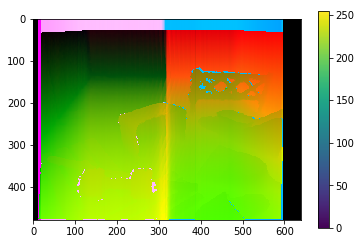

In [38]:
plt.imshow(a.astype(np.uint8))
plt.colorbar()

In [42]:
dataset['box'][0].shape

(480, 640, 3)

In [35]:
dataset.keys()

['box',
 'printer',
 'bicycle',
 'bucket',
 'scene',
 'cart',
 'scanner_',
 'notebook',
 'dustpan',
 'freezer',
 'basket',
 'cleanser_']

In [117]:
len(dataset['bicycle'])

92

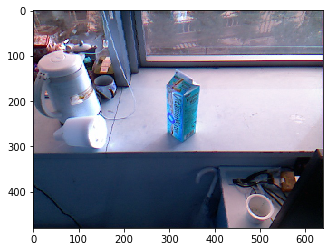

In [36]:
plt.imshow(dataset['box'][0])

In [3]:
DATA_PATH = '../data'

f = h5py.File(osp.join(DATA_PATH, 'nyu_depth_v2_labeled.mat'), 'r')

In [4]:
images = np.swapaxes(f['images'][:], 1, 3)

In [5]:
depths = np.swapaxes(f['depths'][:], 1, 2)

In [6]:
scene_types = []

for ref in f['sceneTypes'][:].ravel():
    scene_types.append(''.join(f[ref][:].view('S2').ravel()))

In [7]:
scene_types = np.array(scene_types)
scene_types

array(['kitchen', 'kitchen', 'office', ..., 'dining_room', 'dining_room',
       'dining_room'], dtype='|S15')

In [8]:
for scene_type in np.unique(scene_types):
    print(scene_type, len(images[scene_types == scene_type]))

('basement', 7)
('bathroom', 121)
('bedroom', 383)
('bookstore', 36)
('cafe', 5)
('classroom', 49)
('computer_lab', 6)
('conference_room', 5)
('dinette', 4)
('dining_room', 117)
('excercise_room', 3)
('foyer', 4)
('furniture_store', 27)
('home_office', 50)
('home_storage', 5)
('indoor_balcony', 2)
('kitchen', 225)
('laundry_room', 3)
('living_room', 221)
('office', 78)
('office_kitchen', 10)
('playroom', 31)
('printer_room', 3)
('reception_room', 17)
('student_lounge', 5)
('study', 25)
('study_room', 7)


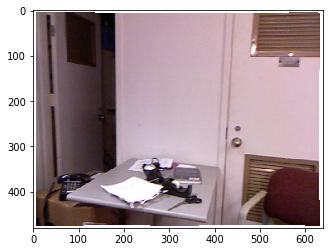

In [9]:
plt.imshow(images[scene_types == 'office'][0])

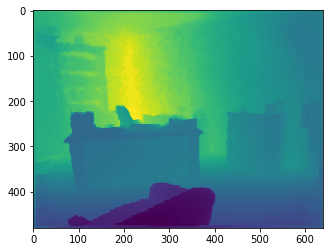

In [10]:
plt.imshow(depths[scene_types == 'home_office'][0])

In [11]:
images_small = np.asarray([cv2.resize(img, (256, 256)) for img in images])
depths_small = np.asarray([cv2.resize(img, (256, 256)) for img in depths]).reshape(-1, 256, 256, 1)

In [12]:
activity1_train, activity1_val = train_test_split(
    np.concatenate([images_small[scene_types == 'office'], depths_small[[scene_types == 'office']]], axis=3),
    test_size = 0.7
)
activity2_train, activity2_val = train_test_split(
    np.concatenate([images_small[scene_types == 'home_office'], depths_small[[scene_types == 'home_office']]], axis=3),
    test_size = 0.7
)

# Straitforward

In [13]:
model = VGG16(include_top=False, weights=None, input_shape=(256, 256, 4))
model.load_weights('../weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True, skip_mismatch=True)
model.trainable = True

/scratch/home/aelphy/py27/local/lib/python2.7/site-packages/keras/applications/imagenet_utils.py:258: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')
/scratch/home/aelphy/py27/local/lib/python2.7/site-packages/keras/engine/topology.py:3269: UserWarning: Skipping loading of weights for layer block1_conv1 due to mismatch in shape ((3, 3, 4, 64) vs (64, 3, 3, 3)).
  weight_values[i].shape))


In [14]:
predictor = Flatten()(model.output)
predictor = Dense(1024, activation='elu')(predictor)
predictor = Dense(512, activation='elu')(predictor)
predictor = Dense(1, activation='sigmoid')(predictor)

predictor = keras.Model([model.input], [predictor])
predictor.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

In [15]:
X_train = np.vstack([activity1_train, activity2_train])
idxs = np.arange(len(X_train))
targets = np.hstack([np.ones(len(activity1_train)), np.zeros(len(activity2_train))])
BATCH_SIZE = 32
NUM_EPOCHS = 100

for i in range(NUM_EPOCHS):
    predictor.fit(
        X_train[idxs], targets[idxs],
        batch_size=BATCH_SIZE, epochs=1
    )
    
    evaluation = predictor.evaluate(
        np.vstack([activity1_val, activity2_val]),
        np.hstack([np.ones(len(activity1_val)), np.zeros(len(activity2_val))])
    )
    
    print('Loss: {}, Acc: {}'.format(evaluation[0], evaluation[1]))

Epoch 1/1
90/90 [==============================] - 1s 9ms/step
Loss: 1.57072993782, Acc: 0.64444444461
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.624745629893, Acc: 0.733333338632
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.780561249124, Acc: 0.67777777248
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.725082786878, Acc: 0.777777776453
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.877342971166, Acc: 0.766666674614
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 0.761431831784, Acc: 0.78888888624
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.804847323232, Acc: 0.722222216924
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 0.751117547353, Acc: 0.777777775129
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.19780503909, Acc: 0.733333333996
Epoch 1/1
90/90 [==============================] - 0s 3ms/st

90/90 [==============================] - 0s 3ms/step
Loss: 1.05049805376, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.05236082077, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.05403009786, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.05562095377, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.05719346735, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.05871889061, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 1.06022923523, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.06174126201, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 1.06305670473, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.064

90/90 [==============================] - 0s 4ms/step
Loss: 1.07934340106, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 1.07985040082, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 1.08037961324, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 1.08089468214, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 1.08139076498, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 1.08186970817, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 4ms/step
Loss: 1.08234965271, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.08288946417, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.08346024089, Acc: 0.733333330684
Epoch 1/1
90/90 [==============================] - 0s 3ms/step
Loss: 1.084

# Siamese classifier

In [16]:
BATCH_SIZE = 16

In [17]:
import models.siamese

model = models.siamese.build(
    (256, 256, 4), 1024, 128, 'vgg16'
)

# NOTE: doesn't work with keras
# model.compile(
#     loss=lambda y, x: tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=x)),
#     optimizer=keras.optimizers.RMSprop(1e-5),
#     metrics=[]
# )

labels = tf.placeholder(tf.float32, name='labels')

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=model.output))

global_step = tf.Variable(0, trainable=False)
train_step = tf.train.RMSPropOptimizer(1e-5).minimize(loss, global_step=global_step)
tf.add_to_collection('train_step', train_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [18]:
with np.load('../weights/siamese_pretrained_imagenet.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))][0]

In [19]:
def reset_fused_model_to_pretrained_state():
    tf.reset_default_graph()
    global model
    global input1
    global input2
    global sess
    global train_step
    global loss
    global labels
    
    model = models.siamese.build(
        (256, 256, 4), 1024, 128, 'vgg16'
    )

    labels = tf.placeholder(tf.float32, name='labels')

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=model.output))

    global_step = tf.Variable(0, trainable=False)
    train_step = tf.train.RMSPropOptimizer(1e-5).minimize(loss, global_step=global_step)
    tf.add_to_collection('train_step', train_step)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    input_1 = model.input[0]
    input_2 = model.input[1]
    
    for i, var in enumerate(tf.trainable_variables()[1:]):
        sess.run(var.assign(param_values[i + 1]))

In [20]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def predict(model, inputs):
    return sigmoid(sess.run(model.output, feed_dict={model.input[0] : inputs[0], model.input[1] : inputs[1]}))

def do_test3(test_img, label, g):
    tets_metric1 = 0
    for batch in doors.test_iterate_minibatches(test_img, g.closed_doors, BATCH_SIZE):
        tets_metric1 += predict(model, batch).sum()
    mean1 = tets_metric1 / len(g.closed_doors)
    
    tets_metric2 = 0
    for batch in doors.test_iterate_minibatches(test_img, g.open_doors, BATCH_SIZE):
        tets_metric2 += predict(model, batch).sum()
    mean2 = tets_metric2 / len(g.open_doors)
    
    answer = np.argmin([mean1, mean2])
    
    return answer == label, (mean1, mean2), test_img

def do_test4(test_img, label, g, k):
    tets_metric1 = 0
    idxs = np.random.choice(len(g.closed_doors), size=k)
    for batch in doors.test_iterate_minibatches(test_img, g.closed_doors[idxs], BATCH_SIZE):
        tets_metric1 += predict(model, batch).sum()
    mean1 = tets_metric1 / len(g.closed_doors)
    
    tets_metric2 = 0
    idxs = np.random.choice(len(g.open_doors), size=k)
    for batch in doors.test_iterate_minibatches(test_img, g.open_doors[idxs], BATCH_SIZE):
        tets_metric2 += predict(model, batch).sum()
    mean2 = tets_metric2 / len(g.open_doors)
    
    answer = np.argmin([mean1, mean2])
    
    return answer == label, (mean1, mean2), test_img

In [21]:
import utils.doors_generator as doors

Xc_open = activity1_train
Xc_closed = activity2_train

Xc_open_test = activity1_val
Xc_closed_test = activity2_val

paired_doors_generator_object = doors.MinibatchGenerator(Xc_open, Xc_closed, BATCH_SIZE)
paired_doors_generator = paired_doors_generator_object.run()

reset_fused_model_to_pretrained_state()

In [22]:
cum_loss = 0
num_epochs = 0
    
for i in range(6000):
    b_l, b_r, b_sim = paired_doors_generator.next()

    _, l = sess.run([train_step, loss],
        feed_dict={model.input[0]: b_l, model.input[1]: b_r, labels: b_sim})
    
    cum_loss += l
    num_epochs += 1

    if i % 100 == 0:
        print "\r#%d - Loss"%i, cum_loss / num_epochs
        cum_loss = 0
        num_epochs = 0

#0 - Loss 0.7065938711166382
#100 - Loss 0.7034383785724639
#200 - Loss 0.4630737678706646
#300 - Loss 0.03896893745230045
#400 - Loss 0.015408247069572098
#500 - Loss 0.0005521581092034467
#600 - Loss 0.0035989916576181715
#700 - Loss 4.249586536161587e-05


KeyboardInterrupt: 

In [23]:
def test(k):
    scores = []
    for im in Xc_closed_test:
        scores.append(do_test4(im, 0, paired_doors_generator_object, k))

    for im in Xc_open_test:
        scores.append(do_test4(im, 1, paired_doors_generator_object, k))

    total = 0

    for s in scores:
        total += s[0]

    return total / float(len(scores))

In [24]:
test(1)

0.7444444444444445

In [25]:
test(6)

0.7666666666666667

In [26]:
scores = []
for im in Xc_closed_test:
    scores.append(do_test3(im, 0, paired_doors_generator_object))

for im in Xc_open_test:
    scores.append(do_test3(im, 1, paired_doors_generator_object))

total = 0

for s in scores:
    total += s[0]

total / float(len(scores))

0.7888888888888889